In [73]:
import numpy as np
import queue
import scipy.constants as spc
import matplotlib.pyplot as plt

In [74]:
a    = 5.431
hbar  = spc.hbar
           
_2pi_over_a = 2*np.pi / a
sqrt3 = np.sqrt(3)

# params from (Phys. Rev. B 69 115201 (2004)

# two-centre Slater–Koster integrals
V = {
    'ss_sigma'      : -1.95933,
    's_star_s_star' : -4.24135,
    'ss_star_sigma' : -1.52230,
    'sp_sigma'      :  3.02562,
    's_star_p_sigma':  3.15565,
    'sd_sigma'      : -2.28485,
    's_star_d_sigma': -0.80993,
    'pp_sigma'      :  4.10364,
    'pp_pi'         : -1.51801,
    'pd_sigma'      : -1.35554,
    'pd_pi'         :  2.38479,
    'dd_sigma'      : -1.68136,
    'dd_pi'         :  2.58880,
    'dd_delta'      : -1.81400,
    
    'h_si_ss': -4.859509,
    'h_si_sp': 3.776178,
    'h_si_ss*': 0,
    'h_si_sd': -.007703,

    # atomic spin-orbit coupling (p-manifold)
    'SOC'           :  0.01989
}

# on-site energies 
E = {
    's'   : -2.15168,
    'px'  :  4.22925, 'py' : 4.22925, 'pz' : 4.22925,
    'dxy' : 13.78950, 'dyz': 13.78950, 'dzx': 13.78950,
    'dx2y2':13.78950, 'dz2': 13.78950,
    's*'  : 19.11650, 'HS' : -3.056510, 'delta_Si' : -0.276789, 'sp3': 10
}


H_SK = {
        ('s',  's')      : lambda l,m,n,V:  V['h_si_ss'],
    ('s',  's*')     : lambda l,m,n,V:  V['h_si_ss*'],
    ('s*', 's')      : lambda l,m,n,V:  V['h_si_ss*'],

    # ---------------- s – p  -----------------------
    ('s',  'px')     : lambda l,m,n,V:  l * V['h_si_sp'],
    ('px', 's')      : lambda l,m,n,V: -l * V['h_si_sp'],
    ('s',  'py')     : lambda l,m,n,V:  m * V['h_si_sp'],
    ('py', 's')      : lambda l,m,n,V: -m * V['h_si_sp'],
    ('s',  'pz')     : lambda l,m,n,V:  n * V['h_si_sp'],
    ('pz', 's')      : lambda l,m,n,V: -n * V['h_si_sp'],


    # ---------------- s – d  -----------------------
    ('s','dxy')      : lambda l,m,n,    V:  sqrt3*l*m               * V['h_si_sd'],
    ('dxy','s')      : lambda l,m,n,V:  sqrt3*l*m               * V['h_si_sd'],
    ('s','dyz')      : lambda l,m,n,V:  sqrt3*m*n               * V['h_si_sd'],
    ('dyz','s')      : lambda l,m,n,V:  sqrt3*m*n               * V['h_si_sd'],
    ('s','dzx')      : lambda l,m,n,V:  sqrt3*n*l               * V['h_si_sd'],
    ('dzx','s')      : lambda l,m,n,V:  sqrt3*n*l               * V['h_si_sd'],
    ('s','dx2y2')    : lambda l,m,n,V: (sqrt3/2)*(l**2-m**2)    * V['h_si_sd'],
    ('dx2y2','s')    : lambda l,m,n,V: (sqrt3/2)*(l**2-m**2)    * V['h_si_sd'],
    ('s','dz2')      : lambda l,m,n,V:  0.5*(3*n**2-1)          * V['h_si_sd'],
    ('dz2','s')      : lambda l,m,n,V:  0.5*(3*n**2-1)          * V['h_si_sd'],

}



SK = {
    # ---------------- s / s* blocks ----------------
    ('s',  's')      : lambda l,m,n,V:  V['ss_sigma'],
    ('s',  's*')     : lambda l,m,n,V:  V['ss_star_sigma'],
    ('s*', 's')      : lambda l,m,n,V:  V['ss_star_sigma'],
    ('s*', 's*')     : lambda l,m,n,V:  V['s_star_s_star'],

    # ---------------- s – p  -----------------------
    ('s',  'px')     : lambda l,m,n,V:  l * V['sp_sigma'],
    ('px', 's')      : lambda l,m,n,V: -l * V['sp_sigma'],
    ('s',  'py')     : lambda l,m,n,V:  m * V['sp_sigma'],
    ('py', 's')      : lambda l,m,n,V: -m * V['sp_sigma'],
    ('s',  'pz')     : lambda l,m,n,V:  n * V['sp_sigma'],
    ('pz', 's')      : lambda l,m,n,V: -n * V['sp_sigma'],

    # ---------------- s* – p  ----------------------
    ('s*','px')      : lambda l,m,n,V:  l * V['s_star_p_sigma'],
    ('px','s*')      : lambda l,m,n,V: -l * V['s_star_p_sigma'],
    ('s*','py')      : lambda l,m,n,V:  m * V['s_star_p_sigma'],
    ('py','s*')      : lambda l,m,n,V: -m * V['s_star_p_sigma'],
    ('s*','pz')      : lambda l,m,n,V:  n * V['s_star_p_sigma'],
    ('pz','s*')      : lambda l,m,n,V: -n * V['s_star_p_sigma'],

    # ---------------- s – d  -----------------------
    ('s','dxy')      : lambda l,m,n,    V:  sqrt3*l*m               * V['sd_sigma'],
    ('dxy','s')      : lambda l,m,n,V:  sqrt3*l*m               * V['sd_sigma'],
    ('s','dyz')      : lambda l,m,n,V:  sqrt3*m*n               * V['sd_sigma'],
    ('dyz','s')      : lambda l,m,n,V:  sqrt3*m*n               * V['sd_sigma'],
    ('s','dzx')      : lambda l,m,n,V:  sqrt3*n*l               * V['sd_sigma'],
    ('dzx','s')      : lambda l,m,n,V:  sqrt3*n*l               * V['sd_sigma'],
    ('s','dx2y2')    : lambda l,m,n,V: (sqrt3/2)*(l**2-m**2)    * V['sd_sigma'],
    ('dx2y2','s')    : lambda l,m,n,V: (sqrt3/2)*(l**2-m**2)    * V['sd_sigma'],
    ('s','dz2')      : lambda l,m,n,V:  0.5*(3*n**2-1)          * V['sd_sigma'],
    ('dz2','s')      : lambda l,m,n,V:  0.5*(3*n**2-1)          * V['sd_sigma'],

    # ---------------- s* – d  ----------------------
    ('s*','dxy')     : lambda l,m,n,V:  sqrt3*l*m               * V['s_star_d_sigma'],
    ('dxy','s*')     : lambda l,m,n,V:  sqrt3*l*m               * V['s_star_d_sigma'],
    ('s*','dyz')     : lambda l,m,n,V:  sqrt3*m*n               * V['s_star_d_sigma'],
    ('dyz','s*')     : lambda l,m,n,V:  sqrt3*m*n               * V['s_star_d_sigma'],
    ('s*','dzx')     : lambda l,m,n,V:  sqrt3*n*l               * V['s_star_d_sigma'],
    ('dzx','s*')     : lambda l,m,n,V:  sqrt3*n*l               * V['s_star_d_sigma'],
    ('s*','dx2y2')   : lambda l,m,n,V: (sqrt3/2)*(l**2-m**2)    * V['s_star_d_sigma'],
    ('dx2y2','s*')   : lambda l,m,n,V: (sqrt3/2)*(l**2-m**2)    * V['s_star_d_sigma'],
    ('s*','dz2')     : lambda l,m,n,V:  0.5*(3*n**2-1)          * V['s_star_d_sigma'],
    ('dz2','s*')     : lambda l,m,n,V:  0.5*(3*n**2-1)          * V['s_star_d_sigma'],

    # ---------------- p – p  -----------------------
    ('px','px')      : lambda l,m,n,V:  l**2 * V['pp_sigma'] + (1-l**2) * V['pp_pi'],
    ('py','py')      : lambda l,m,n,V:  m**2 * V['pp_sigma'] + (1-m**2) * V['pp_pi'],
    ('pz','pz')      : lambda l,m,n,V:  n**2 * V['pp_sigma'] + (1-n**2) * V['pp_pi'],
    ('px','py')      : lambda l,m,n,V:  l*m * (V['pp_sigma'] - V['pp_pi']),
    ('py','px')      : lambda l,m,n,V:  l*m * (V['pp_sigma'] - V['pp_pi']),
    ('px','pz')      : lambda l,m,n,V:  l*n * (V['pp_sigma'] - V['pp_pi']),
    ('pz','px')      : lambda l,m,n,V:  l*n * (V['pp_sigma'] - V['pp_pi']),
    ('py','pz')      : lambda l,m,n,V:  m*n * (V['pp_sigma'] - V['pp_pi']),
    ('pz','py')      : lambda l,m,n,V:  m*n * (V['pp_sigma'] - V['pp_pi']),

    # ---------------- p – d  (all 30 = 15×2) --------
    ('px','dxy')     : lambda l,m,n,V:  sqrt3*l**2*m                * V['pd_sigma']
                                       + m*(1-2*l**2)              * V['pd_pi'],
    ('dxy','px')     : lambda l,m,n,V:  sqrt3*l**2*m                * -V['pd_sigma']
                                       + m*(1-2*l**2)              * -V['pd_pi'],

    ('px','dyz')     : lambda l,m,n,V:  sqrt3*l*m*n                 * V['pd_sigma']
                                       - 2*l*m*n                   * V['pd_pi'],
    ('dyz','px')     : lambda l,m,n,V:  sqrt3*l*m*n                 * -V['pd_sigma']
                                       - 2*l*m*n                   * -V['pd_pi'],

    ('px','dzx')     : lambda l,m,n,V:  sqrt3*l**2*n                * V['pd_sigma']
                                       + n*(1-2*l**2)              * V['pd_pi'],
    ('dzx','px')     : lambda l,m,n,V:  sqrt3*l**2*n                * -V['pd_sigma']
                                       + n*(1-2*l**2)              * -V['pd_pi'],

    ('px','dx2y2')   : lambda l,m,n,V: (sqrt3/2)*l*(l**2-m**2)      * V['pd_sigma']
                                       + l*(1-l**2 + m**2)             * V['pd_pi'],
    ('dx2y2','px')   : lambda l,m,n,V: (sqrt3/2)*l*(l**2-m**2)      * -V['pd_sigma']
                                       + l*(1-l**2 + m**2)             * -V['pd_pi'],

    ('px','dz2')     : lambda l,m,n,V:  l*(n**2 - 0.5*(l**2+m**2))             * V['pd_sigma']
                                      -sqrt3 * l * n**2              * V['pd_pi'],
    ('dz2','px')     : lambda l,m,n,V: l*(n**2 - 0.5*(l**2+m**2))             * -V['pd_sigma']
                                      -sqrt3 * l * n**2                * -V['pd_pi'],

    ('py','dxy')     : lambda l,m,n,V:  sqrt3*l*m**2                * V['pd_sigma']
                                       + l*(1-2*m**2)              * V['pd_pi'],
    ('dxy','py')     : lambda l,m,n,V:  sqrt3*l*m**2                * -V['pd_sigma']
                                       + l*(1-2*m**2)              * -V['pd_pi'],

    ('py','dyz')     : lambda l,m,n,V:  sqrt3*m**2*n         * V['pd_sigma']
                                       + n*(1-2*m**2)            * V['pd_pi'],
    ('dyz','py')     : lambda l,m,n,V:  sqrt3*m**2*n          * -V['pd_sigma']
                                       + n*(1-2*m**2)            * -V['pd_pi'],

    ('py','dzx')     : lambda l,m,n,V:  sqrt3*l*m*n                 * V['pd_sigma']
                                       - 2*l*m*n                   * V['pd_pi'],
    ('dzx','py')     : lambda l,m,n,V:  sqrt3*l*m*n                 * -V['pd_sigma']
                                       - 2*l*m*n                   * -V['pd_pi'],

    ('py','dx2y2')   : lambda l,m,n,V: (sqrt3/2)*m*(m**2-l**2)      * V['pd_sigma']
                                       - m*(1 + l**2 -m**2)             * V['pd_pi'],
    ('dx2y2','py')   : lambda l,m,n,V: (sqrt3/2)*m*(m**2-l**2)      * -V['pd_sigma']
                                       - m*(1 + l**2 -m**2)             * -V['pd_pi'],

    ('py','dz2')     : lambda l,m,n,V: m * (n**2 - (l**2 + m**2 ) /2)              * V['pd_sigma']
                                       -sqrt3 * m * n**2                * V['pd_pi'],
    ('dz2','py')     : lambda l,m,n,V: m * (n**2 - (l**2 + m**2 ) /2)               * -V['pd_sigma']
                                       -sqrt3 * m * n**2                 * -V['pd_pi'],

    ('pz','dxy')     : lambda l,m,n,V:  sqrt3*l*m*n                 * V['pd_sigma']
                                       - 2*l*m*n                   * V['pd_pi'],
    ('dxy','pz')     : lambda l,m,n,V:  sqrt3*l*m*n                 * -V['pd_sigma']
                                       - 2*l*m*n                   * -V['pd_pi'],

    ('pz','dyz')     : lambda l,m,n,V:  sqrt3*n**2*m                * V['pd_sigma']
                                       + m*(1-2*n**2)              * V['pd_pi'],
    ('dyz','pz')     : lambda l,m,n,V:  sqrt3*n**2*m                * -V['pd_sigma']
                                       + m*(1-2*n**2)              * -V['pd_pi'],

    ('pz','dzx')     : lambda l,m,n,V:  sqrt3*l*n**2                * V['pd_sigma']
                                       + l*(1-2*n**2)              * V['pd_pi'],
    ('dzx','pz')     : lambda l,m,n,V:  sqrt3*l*n**2                * -V['pd_sigma']
                                       + l*(1-2*n**2)              * -V['pd_pi'],

    ('pz','dx2y2')   : lambda l,m,n,V: (sqrt3/2)*n*(l**2-m**2)      * V['pd_sigma']
                                       - n*(l**2-m**2)      * V['pd_pi'],
    ('dx2y2','pz')   : lambda l,m,n,V: (sqrt3/2)*n*(l**2-m**2)      * -V['pd_sigma']
                                       - n*(l**2-m**2)     * -V['pd_pi'],
                                       
    ('pz','dz2')     : lambda l,m,n,V: n*(n**2 - 0.5*(l**2+m**2))             * V['pd_sigma']
                                       + sqrt3 * n * (l**2 + m**2)                   * V['pd_pi'],
    ('dz2','pz')     : lambda l,m,n,V: n*(n**2 - 0.5*(l**2+m**2))             * -V['pd_sigma']
                                        + sqrt3 * n * (l**2 + m**2)              * -V['pd_pi'],

    # ---------------- d – d  (15 independent + symmetry) ----------
    # ---- diagonals ----
    ('dxy','dxy')    : lambda l,m,n,V: 3*l**2*m**2                    * V['dd_sigma']
                                       + (l**2+m**2-4*l**2*m**2)     * V['dd_pi']
                                       + (n**2 + l**2*m**2)          * V['dd_delta'],

    ('dyz','dyz')    : lambda l,m,n,V: 3*m**2*n**2                    * V['dd_sigma']
                                       + (m**2+n**2-4*m**2*n**2)     * V['dd_pi']
                                       + (l**2 + m**2*n**2)          * V['dd_delta'],

    ('dzx','dzx')    : lambda l,m,n,V: 3*l**2*n**2                    * V['dd_sigma']
                                       + (l**2+n**2-4*l**2*n**2)     * V['dd_pi']
                                       + (m**2 + l**2*n**2)          * V['dd_delta'],

    ('dx2y2','dx2y2'): lambda l,m,n,V: 0.75*(l**2-m**2)**2            * V['dd_sigma']
                                       + (l**2+m**2-(l**2-m**2)**2)  * V['dd_pi']
                                       + (n**2+0.25*(l**2-m**2)**2)  * V['dd_delta'],

    ('dz2','dz2')    : lambda l,m,n,V: (n**2-0.5*(l**2+m**2))**2      * V['dd_sigma']
                                       + 3*n**2*(l**2+m**2)          * V['dd_pi']
                                       + 0.75*(l**2+m**2)**2         * V['dd_delta'],

    # ---- off-diagonals (each listed once; symmetry implied) ----
    ('dxy','dyz')    : lambda l,m,n,V: 3*l*m**2*n                     * V['dd_sigma']
                                       + l*n*(1-4*m**2)              * V['dd_pi']
                                       + l*n*(m**2-1)                * V['dd_delta'],
    ('dyz','dxy')    : lambda l,m,n,V: 3*l*m**2*n                     * V['dd_sigma']
                                       + l*n*(1-4*m**2)              * V['dd_pi']
                                       + l*n*(m**2-1)                * V['dd_delta'],

    ('dxy','dzx')    : lambda l,m,n,V: 3*m*n*l**2                     * V['dd_sigma']
                                       + m*n*(1-4*l**2)              * V['dd_pi']
                                       + m*n*(l**2-1)                * V['dd_delta'],
    ('dzx','dxy')    : lambda l,m,n,V: 3*m*n*l**2                     * V['dd_sigma']
                                       + m*n*(1-4*l**2)              * V['dd_pi']
                                       + m*n*(l**2-1)                * V['dd_delta'],

    ('dxy','dx2y2')  : lambda l,m,n,V: 1.5*l*m*(l**2-m**2)            * V['dd_sigma']
                                       + 2*l*m*(m**2-l**2)           * V['dd_pi']
                                       + 0.5*l*m*(l**2-m**2)         * V['dd_delta'],
    ('dx2y2','dxy')  : lambda l,m,n,V: 1.5*l*m*(l**2-m**2)            * V['dd_sigma']
                                       + 2*l*m*(m**2-l**2)           * V['dd_pi']
                                       + 0.5*l*m*(l**2-m**2)         * V['dd_delta'],

    ('dxy','dz2')    : lambda l,m,n,V: sqrt3*l*m*(n**2-0.5*(l**2+m**2))*V['dd_sigma']
                                       -2*sqrt3*l*m*n**2             * V['dd_pi']
                                       +0.5*sqrt3*l*m*(1+n**2)       * V['dd_delta'],
    ('dz2','dxy')    : lambda l,m,n,V: sqrt3*l*m*(n**2-0.5*(l**2+m**2))*V['dd_sigma']
                                       -2*sqrt3*l*m*n**2             * V['dd_pi']
                                       +0.5*sqrt3*l*m*(1+n**2)       * V['dd_delta'],

    ('dyz','dzx')    : lambda l,m,n,V: 3*l*m*n**2                     * V['dd_sigma']
                                       + l*m*(1-4*n**2)              * V['dd_pi']
                                       + l*m*(n**2-1)                * V['dd_delta'],
    ('dzx','dyz')    : lambda l,m,n,V: 3*l*m*n**2                     * V['dd_sigma']
                                       + l*m*(1-4*n**2)              * V['dd_pi']
                                       + l*m*(n**2-1)                * V['dd_delta'],

    ('dyz','dx2y2')  : lambda l,m,n,V: 1.5*m*n*(l**2-m**2)            * V['dd_sigma']
                                       - m*n*(1+2*(l**2-m**2))       * V['dd_pi']
                                       + m*n*(1+0.5*(l**2-m**2))     * V['dd_delta'],
    ('dx2y2','dyz')  : lambda l,m,n,V: 1.5*m*n*(l**2-m**2)            * V['dd_sigma']
                                       - m*n*(1+2*(l**2-m**2))       * V['dd_pi']
                                       + m*n*(1+0.5*(l**2-m**2))     * V['dd_delta'],

    ('dyz','dz2')    : lambda l,m,n,V: sqrt3*m*n*(n**2-0.5*(l**2+m**2))*V['dd_sigma']
                                       + sqrt3*m*n*(l**2+m**2-n**2) * V['dd_pi']
                                       - 0.5*sqrt3*m*n*(l**2+m**2)  * V['dd_delta'],
    ('dz2','dyz')    : lambda l,m,n,V: sqrt3*m*n*(n**2-0.5*(l**2+m**2))*V['dd_sigma']
                                       + sqrt3*m*n*(l**2+m**2-n**2) * V['dd_pi']
                                       - 0.5*sqrt3*m*n*(l**2+m**2)  * V['dd_delta'],

    ('dzx','dx2y2')  : lambda l,m,n,V: 1.5*l*n*(l**2-m**2)            * V['dd_sigma']
                                       + n*l*(1-2*(l**2-m**2))       * V['dd_pi']
                                       - n*l*(1-0.5*(l**2-m**2))     * V['dd_delta'],
    ('dx2y2','dzx')  : lambda l,m,n,V: 1.5*l*n*(l**2-m**2)            * V['dd_sigma']
                                       + n*l*(1-2*(l**2-m**2))       * V['dd_pi']
                                       - n*l*(1-0.5*(l**2-m**2))     * V['dd_delta'],

    ('dzx','dz2')    : lambda l,m,n,V: sqrt3*n*l*(n**2-0.5*(l**2+m**2))*V['dd_sigma']
                                       + sqrt3*n*l*(l**2+m**2-n**2) * V['dd_pi']
                                       - 0.5*sqrt3*n*l*(l**2+m**2)  * V['dd_delta'],
    ('dz2','dzx')    : lambda l,m,n,V: sqrt3*n*l*(n**2-0.5*(l**2+m**2))*V['dd_sigma']
                                       + sqrt3*n*l*(l**2+m**2-n**2) * V['dd_pi']
                                       - 0.5*sqrt3*n*l*(l**2+m**2)  * V['dd_delta'],

    ('dx2y2','dz2')  : lambda l,m,n,V: 0.5*sqrt3*(l**2-m**2)*(n**2-0.5*(l**2+m**2))*V['dd_sigma']
                                       + sqrt3*n**2*(m**2-l**2)     * V['dd_pi']
                                       + 0.25*sqrt3*(1+n**2)*(l**2-m**2) * V['dd_delta'],
    ('dz2','dx2y2')  : lambda l,m,n,V: 0.5*sqrt3*(l**2-m**2)*(n**2-0.5*(l**2+m**2))*V['dd_sigma']
                                       + sqrt3*n**2*(m**2-l**2)     * V['dd_pi']
                                       + 0.25*sqrt3*(1+n**2)*(l**2-m**2) * V['dd_delta'],
}


Es = E['s']
Ep = E['px']             

# orbital-basis Hamiltonian
H_orb = np.diag([Es, Ep, Ep, Ep])

# change-of-basis matrices
U_orb_to_sp3 = 0.5*np.array([[1, 1, 1, 1],
                             [1, 1,-1,-1],
                             [1,-1, 1,-1],
                             [1,-1,-1, 1]])
U_sp3_to_orb = U_orb_to_sp3.T  

a = (Es + 3*Ep)/4.0
b = (Es -   Ep)/4.0
H_sp3_explicit = np.full((4,4), b)
np.fill_diagonal(H_sp3_explicit, a)


# sp3 basis
print(H_sp3_explicit)
# orbital basis 
print(U_orb_to_sp3 @ H_sp3_explicit @ U_orb_to_sp3.T)

[[ 2.6340175 -1.5952325 -1.5952325 -1.5952325]
 [-1.5952325  2.6340175 -1.5952325 -1.5952325]
 [-1.5952325 -1.5952325  2.6340175 -1.5952325]
 [-1.5952325 -1.5952325 -1.5952325  2.6340175]]
[[-2.15168  0.       0.       0.     ]
 [ 0.       4.22925  0.       0.     ]
 [ 0.       0.       4.22925  0.     ]
 [ 0.       0.       0.       4.22925]]


In [75]:
class Atom:
    def __init__(self, x, y, z):
        self.x = x
        self.y = y
        self.z = z
        self.type = "Silicon"

    def __eq__(self, other):
        if isinstance(other, Atom):
            return self.x == other.x and self.y == other.y and self.z == other.z
        return False
    

    def __hash__(self):
        return hash((self.x, self.y, self.z))

    def __repr__(self):
        return f"Atom({self.x}, {self.y}, {self.z})"
    

class UnitCellGeneration:
    _DELTAS = {                       
        0: [(+0.25,+0.25,+0.25), (+0.25,-0.25,-0.25),
            (-0.25,+0.25,-0.25), (-0.25,-0.25,+0.25)],   # type-0 sub-lattice
        1: [(-0.25,-0.25,-0.25), (-0.25,+0.25,+0.25),
            (+0.25,-0.25,+0.25), (+0.25,+0.25,-0.25)]    # type-1 sub-lattice
    }
    
    
    @staticmethod
    def _delta(a, b):   
        return (b.x - a.x, b.y - a.y, b.z - a.z)

    @staticmethod
    def _sublattice(atom):    
        return (round(atom.x*4) + round(atom.y*4) + round(atom.z*4)) & 1
    

    def __init__(self, N):
        self.atoms = {}      # basic graph design 
        self.visited = set() # dfs
        self.N = N
        # base node 
        self.addAtoms(Atom(0, 0, 0), 0)
        self.periodicityFix = {}
        self.atoms_nonPeriodic = self.atoms.copy()
        
        self.hydrogens = {}
        self.numHydrogens = 0

        for atom in self.atoms:
            
            listofatoms = self.atoms[atom]
            for i in listofatoms:
              
                value = i
                if not self.checkIfAllowed(value):
                    # we need to update the periodic neighbor
                    delta = (value.x - atom.x, value.y - atom.y, value.z - atom.z)
                    try:
                        newNeighbor = Atom((atom.x + delta[0]) % 1, (atom.y + delta[1]) % 1, (atom.z + delta[2]))
                        self.atoms[newNeighbor].append(atom)
                       
                    except:
                        print(atom, value, newNeighbor)
                        return 
                    
            

            self.atoms[atom] = list(filter(self.checkIfAllowed, self.atoms[atom]))
            
            self.hydrogen_passification()
            


    def checkIfAllowed(self, newAtom):
        # check if atoms are in proper cell 
        return not (newAtom.x < 0 or newAtom.y < 0 or newAtom.z < 0 or newAtom.z >= self.N or newAtom.x >= 1 or newAtom.y >= 1)
        
    def checkIfAllowedInZDirection(self, newAtom):
        return not (newAtom.z < 0 or newAtom.z >= self.N)

    def addAtoms(self, base, atomType):
        # dfs 
        if base in self.visited:
            return
        self.visited.add(base)

        if atomType == 0:
            atom1 = Atom(base.x + 0.25, base.y + 0.25, base.z + 0.25)
            atom2 = Atom(base.x + 0.25, base.y - 0.25, base.z - 0.25)
            atom3 = Atom(base.x - 0.25, base.y + 0.25, base.z - 0.25)
            atom4 = Atom(base.x - 0.25, base.y - 0.25, base.z + 0.25)
        elif atomType == 1:
            atom1 = Atom(base.x - 0.25, base.y - 0.25, base.z - 0.25)
            atom2 = Atom(base.x - 0.25, base.y + 0.25, base.z + 0.25)
            atom3 = Atom(base.x + 0.25, base.y - 0.25, base.z + 0.25)
            atom4 = Atom(base.x + 0.25, base.y + 0.25, base.z - 0.25)
        else:
            return

        newAtoms = [atom1, atom2, atom3, atom4]
        
        for newAtom in newAtoms:
            
            # If base has no neighbors yet, initialize its neighbor list.
            if self.checkIfAllowedInZDirection(newAtom):
                if base not in self.atoms:
                    self.atoms[base] = [newAtom]
                elif newAtom not in self.atoms[base]:
                    self.atoms[base].append(newAtom)
            
            # Recursively add neighbors (DFS)
            if self.checkIfAllowed(newAtom):
                self.addAtoms(newAtom, (atomType + 1) % 2)
                


    def neighborTable(self): # finds the directional cosines: 
        neighborInformation = {}
        for atom in self.atoms:
            neighborInformation[atom] = {}
            for i in range(len(self.atoms[atom])):
                nonPeriodicNeighbor = self.atoms_nonPeriodic[atom][i]
     
                # Compute the difference vector between neighbor and atom.
                dx = nonPeriodicNeighbor.x - atom.x
                dy = nonPeriodicNeighbor.y - atom.y
                dz = nonPeriodicNeighbor.z - atom.z
                
                delta = (dx, dy, dz)
                newNeighbor = Atom((atom.x + delta[0]) % 1, (atom.y + delta[1]) % 1, (atom.z + delta[2]))
                norm = np.sqrt(dx**2 + dy**2 + dz**2)
                
                # Calculate the directional cosines: l, m, n.
                if norm != 0:
                    l = dx / norm
                    m = dy / norm
                    n = dz / norm
                else:
                    l, m, n = 0.0, 0.0, 0.0
                
                neighborInformation[atom].update({newNeighbor: (delta, l, m, n)})
        
        return neighborInformation
    
    def hydrogen_passification(self):
        # we need to give each hydrogen an index 
        hydrogenIndex = 0
        for atom in self.atoms:
            missing = self.dangling_bonds(atom, only_z=True)
            for hydrogen_ in missing:
                #print(f"silicon atom is: {atom} hydrogen atom is {hydrogen_}")
                
                hydrogen = Atom(hydrogen_[0] + atom.x, hydrogen_[1]+ atom.y, hydrogen_[2] + + atom.z)
                dx,dy,dz = hydrogen_
                norm = np.sqrt(dx**2 + dy**2 + dz**2)
                l = dx / norm
                m = dy / norm
                n = dz / norm
                self.hydrogens[hydrogen] = [atom, hydrogen_, hydrogenIndex, l,m,n]
                hydrogenIndex += 1
                
                
    
    def dangling_bonds(self, atom, only_z= False):
        """
        Return the list of bond-direction vectors that *should* exist for
        `atom` but do not (because the neighbour lies outside the slab).
        """
        missing = []
        for dx, dy, dz in self._DELTAS[self._sublattice(atom)]:
            nx, ny, nz = atom.x + dx, atom.y + dy, atom.z + dz

            # check if it is outside the cell in z direction 
            if nz < 0 or nz >= self.N:
                missing.append((dx, dy, dz))
                continue
            if only_z == False:
                n_atom = Atom(nx % 1, ny % 1, nz)   # wrap in x, y (periodic)
                if n_atom not in self.atoms:        
                    missing.append((dx, dy, dz))

        return missing     
    
    
    # OLD
    
    def determine_hybridization(signs):
        # Extract just the signs
        sign_pattern = np.sign(signs)
        
        # Ensure first sign (s orbital) is positive for consistent comparison
        if sign_pattern[0] < 0:
            sign_pattern = -sign_pattern
        
        # Map each sign pattern to its hybridization index
        if np.array_equal(sign_pattern, [1, 1, 1, 1]):       # Type a
            return 0
        elif np.array_equal(sign_pattern, [1, 1, -1, -1]):   # Type b
            return 1
        elif np.array_equal(sign_pattern, [1, -1, 1, -1]):   # Type c
            return 2
        elif np.array_equal(sign_pattern, [1, -1, -1, 1]):   # Type d
            return 3
        
        return None 
        
        
    def __str__(self):
        s = ""
        for atom, neighbors in self.atoms.items():
            s += f"{atom} -> {neighbors}" + "\n"
            
        return s
    
    

N = 1  # how tall
unit_cell = UnitCellGeneration(N)

print(unit_cell)

print(unit_cell.neighborTable())
print(unit_cell.dangling_bonds(Atom(0,0,0)))
print(unit_cell.hydrogens)

Atom(0, 0, 0) -> [Atom(0.25, 0.25, 0.25), Atom(0.75, 0.75, 0.25)]
Atom(0.25, 0.25, 0.25) -> [Atom(0.0, 0.0, 0.0), Atom(0.0, 0.5, 0.5), Atom(0.5, 0.0, 0.5), Atom(0.5, 0.5, 0.0)]
Atom(0.0, 0.5, 0.5) -> [Atom(0.25, 0.75, 0.75), Atom(0.25, 0.25, 0.25), Atom(0.75, 0.25, 0.75), Atom(0.75, 0.75, 0.25)]
Atom(0.25, 0.75, 0.75) -> [Atom(0.0, 0.5, 0.5), Atom(0.5, 0.0, 0.5)]
Atom(0.5, 0.0, 0.5) -> [Atom(0.75, 0.25, 0.75), Atom(0.25, 0.25, 0.25), Atom(0.25, 0.75, 0.75), Atom(0.75, 0.75, 0.25)]
Atom(0.75, 0.25, 0.75) -> [Atom(0.5, 0.0, 0.5), Atom(0.0, 0.5, 0.5)]
Atom(0.5, 0.5, 0.0) -> [Atom(0.75, 0.75, 0.25), Atom(0.25, 0.25, 0.25)]
Atom(0.75, 0.75, 0.25) -> [Atom(0.5, 0.5, 0.0), Atom(0, 0, 0), Atom(0.0, 0.5, 0.5), Atom(0.5, 0.0, 0.5)]

{Atom(0, 0, 0): {Atom(0.25, 0.25, 0.25): ((0.25, 0.25, 0.25), np.float64(0.5773502691896258), np.float64(0.5773502691896258), np.float64(0.5773502691896258)), Atom(0.75, 0.75, 0.25): ((-0.25, -0.25, 0.25), np.float64(-0.5773502691896258), np.float64(-0.57735026918962

In [76]:
def create_tight_binding(k, N=1, potentialProfile = None):
    if potentialProfile is None:
        potentialProfile = np.zeros(N+1)
    
    
    kx,ky = k
    

    unitCell = UnitCellGeneration(N)
    unitNeighbors = unitCell.neighborTable()
    hydrogens = unitCell.hydrogens
    
    
    
    numSilicon = len(unitNeighbors.keys())
    numHydrogen = len(hydrogens.keys()) * 0
   
    orbitals = ['s', 'px', 'py', 'pz', 'dxy','dyz','dzx','dx2y2','dz2', 's*']
    numOrbitals = len(orbitals)
    size = numSilicon * numOrbitals + numHydrogen * 1
    A = np.zeros((size, size), dtype=complex)    
    
    atomToIndex = {}
    indexToAtom = {}
    for atom_index,atom in enumerate(unitNeighbors):
        atomToIndex[atom] = atom_index
        indexToAtom[atom_index] = atom
    
    
    
    """for atom_index in range(numSilicon):
        for orbIndex, orbital in enumerate(orbitals):
            index = atom_index * 4 + orbIndex
            #print(orbital)
            A[index, index] += E[orbital]

    
    
    for hydrogen in hydrogens.keys():
        information = hydrogens[hydrogen]
        silicon, delta, hIndex, l,m,n = information
        
        siliconIndex = atomToIndex[silicon] #what atom is silicon 
        hydrogenIndex = numSilicon *numOrbitals + hIndex -1
        
        # first update onsite energies of the two 
        for i in range(siliconIndex * numOrbitals, (siliconIndex + 1) * numOrbitals):
            A[i,i] += E['delta_Si']
        
    
        A[hydrogenIndex,hydrogenIndex] += E['HS']
        
        for orbIndex, orb in enumerate(orbitals):
            index_i = hydrogenIndex 
            index_j = siliconIndex * numOrbitals + orbIndex
            hop = H_SK[('s', orb)](l, m, n, V)
            A[index_i,index_j] += hop
            
            A[index_j, index_i] += hop"""
            
            

    # old code with sp3 hybridization 
    for atom_idx, atom in indexToAtom.items():
        hybridizationMatrix = H_sp3_explicit.copy() 

        for delta in unitCell.dangling_bonds(atom):
            signs = np.array([1/4] + list(delta)) * 4
            h = UnitCellGeneration.determine_hybridization(signs)
            hybridizationMatrix[h, h] += E['sp3']          # increase the energy of dangling states 
        
        # if there are no dangling bonds this returns the standard diag matrix with onsite energies 
        onsiteMatrix = U_orb_to_sp3 @ hybridizationMatrix @ U_orb_to_sp3.T # go back to orbital basis 
        
        A[atom_idx*10:atom_idx*10 + 4, atom_idx*10:atom_idx*10 + 4] = onsiteMatrix
        A[atom_idx*10 + 4:atom_idx*10 + 9, atom_idx*10 + 4:atom_idx*10 + 9] = np.eye(5) * E['dxy']
        A[atom_idx*10 + 9,atom_idx*10 + 9] = E['s*']
    
    for atom_index in range(numSilicon):
        atom = indexToAtom[atom_index]
        neighbors = unitNeighbors[atom]
        for orbitalIndex, orbital in enumerate(orbitals):
            index_i = atom_index * numOrbitals + orbitalIndex
            
            effectiveZinPotential = int(atom.z)
            
            A[index_i,index_i] += potentialProfile[effectiveZinPotential]
            
            for neighbor in neighbors.keys():
                delta = neighbors[neighbor][0]
                l,m,n = neighbors[neighbor][1:]
                phase = np.exp(2 * np.pi * 1j * (kx*delta[0] + ky*delta[1])) # blochs theorem does not work 
                
                neighbor_index = atomToIndex[neighbor]       
                
                for secOrbitalIndex, secondOrbital in enumerate(orbitals):
                    index_j = neighbor_index * numOrbitals + secOrbitalIndex
                    
                    hop = SK[(orbital, secondOrbital)](l, m, n, V)
                        
                    A[index_i,index_j] += hop * phase   
            
                
        dagger = lambda A: np.conjugate(A.T)
    if not np.allclose(A, dagger(A)):
        print("H isnt Hermitian")

    eigvals,eigv = np.linalg.eigh(A)
    return eigvals, A
    

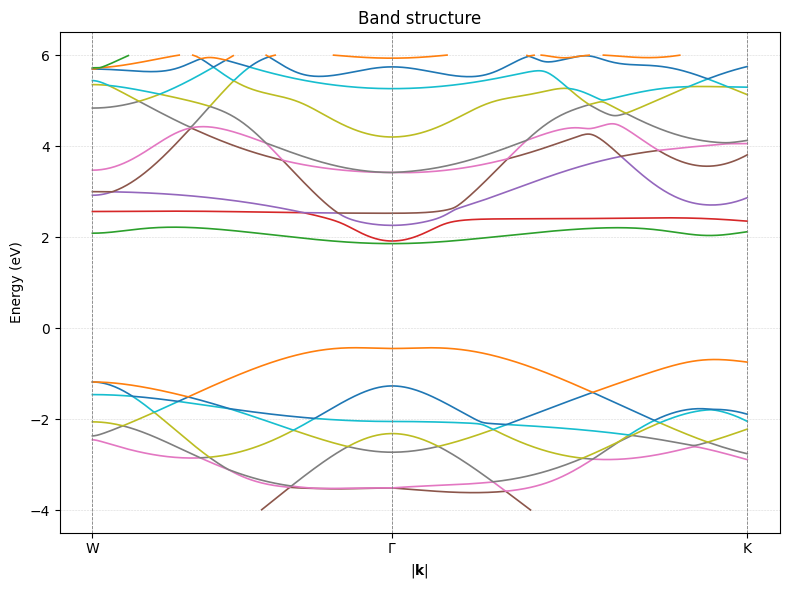

In [77]:
import numpy as np
import matplotlib.pyplot as plt


class BandStructurePlotter:

   
    def __init__(self, N: int, potential_profile: np.ndarray):
        self.N = N
        self.V = np.asarray(potential_profile)
        
        self.k_path = None
        self.k_ticks = None      
        self.energies = None    

    # k space
    @staticmethod
    def _cumulative_distance(k_path):
        d = np.zeros(len(k_path))
        for i in range(1, len(k_path)):
            d[i] = d[i-1] + np.linalg.norm(k_path[i] - k_path[i-1])
        return d

    @staticmethod
    def _segment(a, b, n):
        """n points from a→b (excluding b)."""
        return np.linspace(a, b, n, endpoint=False)

    def build_k_path(self, corner_points, points_per_segment=200):
        """
        corner_points : list of 3-vectors (in Cartesian reciprocal space)
            e.g. [W, Γ, K, …].
        """
        k = []
        for p, q in zip(corner_points[:-1], corner_points[1:]):
            k.extend(self._segment(p, q, points_per_segment))
        k.append(corner_points[-1])          # include the last corner exactly
        self.k_path = np.array(k)
        self.k_ticks = {lbl: i*points_per_segment
                        for i, lbl in enumerate("".join((" " * (len(corner_points)-1))).split())}

    #eigen states
    def _compute_band_structure(self):
        assert self.k_path is not None, "call build_k_path() first"
        Nk = len(self.k_path)
        # get one eigen-spectrum just to know how many bands
        test_E = create_tight_binding(self.k_path[0], self.N, self.V)[0]
        Nb = test_E.size
        self.energies = np.empty((Nk, Nb))
        for i, kvec in enumerate(self.k_path):
            self.energies[i] = np.sort(create_tight_binding(kvec, self.N, self.V)[0].real)

    # plot
    def plot(self, energy_window=None, colour_cycle=None,
             k_labels=None, linewidth=1.2, figsize=(8, 6)):
        """
        energy_window : (Emin, Emax) tuple or None
            Energies outside are masked out (useful to hide surface bands).
        k_labels : dict {label: index} or None
            Override tick labels.  If None, W-Γ-K… order is auto-generated.
        """
        if self.energies is None:
            self._compute_band_structure()

        # x-axis
        k_x = self._cumulative_distance(self.k_path)

        # optional masking
        E = self.energies.copy()
        if energy_window is not None:
            Emin, Emax = energy_window
            E[(E < Emin) | (E > Emax)] = np.nan

        # plotting
        plt.figure(figsize=figsize)
        if colour_cycle:
            plt.gca().set_prop_cycle(color=colour_cycle)

        for band in range(E.shape[1]):
            plt.plot(k_x, E[:, band], lw=linewidth)

        # decorations
        plt.ylabel("Energy (eV)")
        plt.xlabel("$|\\mathbf{k}|$")
        plt.title("Band structure")
        plt.grid(True, ls="--", lw=0.4, alpha=0.5)

        # ticks at high-symmetry points
        if k_labels is None and self.k_ticks:
            k_labels = self.k_ticks
        if k_labels:
            tick_pos = [k_x[idx] for idx in k_labels.values()]
            for x in tick_pos:
                plt.axvline(x, color='grey', ls='--', lw=0.6)
            plt.xticks(tick_pos, list(k_labels.keys()))

        plt.tight_layout()
        plt.show()
# high symmetry points
a = 1.0
G  = np.array([0, 0])
W  = np.array([1/2, 1/2])
K  =np.array([3/4, 3/8])

# plot
N  = 1
plotter = BandStructurePlotter(N, potential_profile=np.zeros(N+1))
plotter.build_k_path([W, G, K], points_per_segment=200)

# custom tick dictionary (same indices you used before)
plotter.plot(energy_window=(-4, 6),
             k_labels={'W': 0,
                       r'$\Gamma$': 200,
                       'K': 400})


In [78]:
import numpy as np
from itertools import product
from multiprocessing import Pool, cpu_count

# create the k grid 
def make_mp_grid(Nk):
    """Return an (Nk3, 3) array of fractional k-vectors (0 … 1) in the 1st BZ."""
    shifts = np.linspace(0, 1, Nk, endpoint=False) + 0.5/Nk   
    klist  = np.array(list(product(shifts, repeat=2)))        

    return klist                                             

def eval_k(k_frac):
    """return the good eigenvalues"""
    eigvals, _ = create_tight_binding(k_frac)    
    vbm = eigvals[eigvals <=  0.0].max()     
    cbm = eigvals[eigvals >=  0.0].min()
    return vbm, cbm, eigvals

# helper method 
def frac_shift(k_frac, delta):
    return (k_frac + delta) % 1.0

#  effective-mass tensor around the CBM
def find_effective_mass(k_min_frac, Nk_coarse, band_idx,
                        resolution_factor=4, a=5.431e-10):


    delta_frac = 1.0 / (Nk_coarse * resolution_factor)        # we want a finer mesh size
    dk = (2*np.pi / a) * delta_frac                       


    k0 = np.asarray(k_min_frac, float)

    # get the good energy
    def E(k_frac):
        evs, _ = create_tight_binding(k_frac)
        return evs[band_idx]


    #shift 
    ei = np.eye(2)

    # Hessian 
    H = np.zeros((2,2))
    for i in range(2):
        # second derivative along axis i
        kp = frac_shift(k0,  +delta_frac * ei[i])
        km = frac_shift(k0,  -delta_frac * ei[i])
        H[i,i] = (E(kp) + E(km) - 2*E(k0)) / dk**2

        # mixed derivatives
        for j in range(i+1, 2):
            kpp = frac_shift(k0, +delta_frac*ei[i] + delta_frac*ei[j])
            kmm = frac_shift(k0, -delta_frac*ei[i] - delta_frac*ei[j])
            kpm = frac_shift(k0, +delta_frac*ei[i] - delta_frac*ei[j])
            kmp = frac_shift(k0, -delta_frac*ei[i] + delta_frac*ei[j])
            H[i,j] = H[j,i] = (E(kpp)+E(kmm)-E(kpm)-E(kmp)) / (4*dk**2)

    # convert eV → J
    H_J = H * spc.e

    # m*  = hbar^2 *
    mstar_SI = spc.hbar**2 * np.linalg.inv(H_J)           # kg
    mstar_me = mstar_SI / spc.m_e                         # in m_e

    prin_m, prin_axes = np.linalg.eigh(mstar_me)
    return mstar_me, prin_m, prin_axes


def scan_full_BZ(Nk=20, store_all=True, n_jobs=None, a=5.431e-10,
                 res_factor=4):
    """
    Nk       : number of k-points per reciprocal-lattice axis (Nk³ total)
    store_all: if True, return the entire E(k) array (size Nk³ × Nb)
    n_jobs   : cores to use; default = all available
    """
    klist = make_mp_grid(Nk)
    nbands = len(create_tight_binding(np.zeros(2))[0])   # quick probe
    
    dk = 1 / Nk
    # ----- parallel diagonalisation -----
    n_jobs = n_jobs or cpu_count()
    with Pool(processes=n_jobs) as pool:
        results = pool.map(eval_k, klist, chunksize=len(klist)//n_jobs)

    # collect extrema
    vbm_E, cbm_E = -np.inf, np.inf
    vbm_data = cbm_data = None
    if store_all:
        all_E = np.empty((len(klist), nbands))
        print(all_E.shape)

    for idx, (v, c, eigs) in enumerate(results):
        if v > vbm_E:
            vbm_E      = v
            vbm_data   = (v, klist[idx], int(np.where(eigs==v)[0][0]))
        if c < cbm_E:
            
            cbm_E      = c
            cbm_data   = (c, klist[idx], int(np.where(eigs==c)[0][0]))
        if store_all:
            all_E[idx] = eigs

    
    
    
    Egap = cbm_E - vbm_E
    print(f"Fundamental gap = {Egap:.4f} eV")
    print("VBM : E = {:.4f} eV  at k_frac = {}".format(*vbm_data[:2]))
    print("CBM : E = {:.4f} eV  at k_frac = {}".format(*cbm_data[:2]))
    print("Direct gap" if np.allclose(vbm_data[1], cbm_data[1]) else "Indirect gap")
    mstar, prin_m, prin_ax = find_effective_mass(cbm_data[1], Nk,
                                                 cbm_data[2],
                                                 resolution_factor=res_factor,
                                                 a=a)
    print("\nEffective-mass tensor at CBM:\n", mstar)
    print("Principal massesₑ:\n", prin_m)

    if store_all:
        return (Egap, vbm_data, cbm_data,
                klist, all_E,
                mstar, prin_m, prin_ax)
    return Egap, vbm_data, cbm_data, mstar, prin_m, prin_ax


Egap, vbm, cbm, klist, allE, M, m_prin, axes = \
        scan_full_BZ(Nk=30, store_all=True, res_factor=6)

print("\ndelta-valley:  m_l = {:.3f}  m_t = {:.3f}  (in me)"
      .format(m_prin.max(), m_prin.min()))



(900, 80)
Fundamental gap = 2.2913 eV
VBM : E = -0.4337 eV  at k_frac = [0.05       0.08333333]
CBM : E = 1.8576 eV  at k_frac = [0.01666667 0.01666667]
Indirect gap

Effective-mass tensor at CBM:
 [[1.47592994 0.16809075]
 [0.16809075 1.47592994]]
Principal massesₑ:
 [1.30783919 1.64402069]

delta-valley:  m_l = 1.644  m_t = 1.308  (in me)


In [79]:
# broken 

def getTheDOS(E, N, sigma):
    def gaussian(En):
        return 1 / np.sqrt(2 * np.pi * sigma) * np.exp(-(E - En)**2 / (2 * sigma))
    D = 0
    for kx in np.linspace(-1,1,50):
        kx = 2 *np.pi / a * kx
        for ky in np.linspace(-1,1,50):
                energies = create_tight_binding(np.array([kx, ky, 0]), N, potentialProfile)[0]
                for en in energies:
                    D += gaussian(en)
            
    
    return D
        

def getFermiLevel(N, dos, dosE):
    kbT = 0.0257   
    fermi = lambda x: 1.0 / (1.0 + np.exp(x / kbT))
    
    def integralGuess(x):
        dE = dosE[1] - dosE[0]
    
        occupancy = fermi(dosE - x)  
    
        return dE * np.sum(dos * occupancy)
    
    numberOfElectrons = 4 * N * 8

    E_F = 0.55
    err = integralGuess(E_F) - numberOfElectrons

    step = 0.01
    while abs(err) > 2.0:
        if err < 0:

            E_F -= step
        else:
            E_F += step
        
        err = integralGuess(E_F) - numberOfElectrons
    
    return E_F

    

### old sp3

In [80]:

def create_tight_binding(k, N, potentialProfile):
    kx,ky,kz = k
    unitCell = UnitCellGeneration(N)
    unitNeighbors = unitCell.neighborTable()
    numSilicon = len(unitNeighbors.keys())
    size = numSilicon* 4 # sp3
    A = np.zeros((size, size), dtype=complex)    
    
    atomToIndex = {}
    indexToAtom = {}
    for atom_index,atom in enumerate(unitNeighbors):
        atomToIndex[atom] = atom_index
        indexToAtom[atom_index] = atom
    
  
    orbitals = ['s', 'px', 'py', 'pz']
    
    # old code with no dangling bonds 
    """for atom_index in range(numSilicon):
        for orbIndex, orbital in enumerate(orbitals):
            index = atom_index * 4 + orbIndex
            #print(orbital)
            A[index, index] += E[orbital]"""

            
    for atom_idx, atom in indexToAtom.items():
        hybridizationMatrix = H_sp3_explicit.copy() 

        for delta in unitCell.dangling_bonds(atom):
            signs = np.array([1/4] + list(delta)) * 4
            h = UnitCellGeneration.determine_hybridization(signs)
            hybridizationMatrix[h, h] += E['sp3']          # increase the energy of dangling states 
        
        # if there are no dangling bonds this returns the standard diag matrix with onsite energies 
        onsiteMatrix = U_orb_to_sp3 @ hybridizationMatrix @ U_orb_to_sp3.T # go back to orbital basis 
        A[atom_idx*4:(atom_idx+1)*4, atom_idx*4:(atom_idx+1)*4] = onsiteMatrix
    
    for atom_index in range(numSilicon):
        atom = indexToAtom[atom_index]
        neighbors = unitNeighbors[atom]
        for orbitalIndex, orbital in enumerate(orbitals):
            index_i = atom_index * 4 + orbitalIndex
            
            effectiveZinPotential = int(atom.z)
            
            A[index_i,index_i] += potentialProfile[effectiveZinPotential]
            
            for neighbor in neighbors.keys():
                delta = neighbors[neighbor][0]
                l,m,n = neighbors[neighbor][1:]
                phase = np.exp(1j * (kx*delta[0] + ky*delta[1])) # blochs theorem does not work 
                
                neighbor_index = atomToIndex[neighbor]       
                
                for secOrbitalIndex, secondOrbital in enumerate(orbitals):
                    index_j = neighbor_index * 4 + secOrbitalIndex
                    
                    hop = SK[(orbital, secondOrbital)](l, m, n, V)
                        
                    A[index_i,index_j] += hop * phase   
            
                
        dagger = lambda A: np.conjugate(A.T)
    if not np.allclose(A, dagger(A)):
        print("H isnt Hermitian")

    eigvals,eigv = np.linalg.eigh(A)
    return eigvals, eigv, A